# Juan Ruiz Juan Ortega Juan Cerquera
# Cinematica inversa robot Puma560

### Librerias

In [394]:
import pybullet
import sympy as sp
import numpy as np
from spatialmath import SE3
import roboticstoolbox as rtb
import matplotlib.pyplot as plt
from roboticstoolbox import jtraj, ctraj, mtraj, quintic

### DH Puma560 en clase de robotic-toolbox

In [395]:
puma560 = rtb.models.DH.Puma560()
puma560

DHRobot: Puma 560 (by Unimation), 6 joints (RRRRRR), dynamics, geometry, standard DH parameters
┌────┬────────┬────────┬────────┬─────────┬────────┐
│θⱼ  │   dⱼ   │   aⱼ   │   ⍺ⱼ   │   q⁻    │   q⁺   │
├────┼────────┼────────┼────────┼─────────┼────────┤
│ q1 │ 0.6718 │      0 │  90.0° │ -160.0° │ 160.0° │
│ q2 │      0 │ 0.4318 │   0.0° │ -110.0° │ 110.0° │
│ q3 │   0.15 │ 0.0203 │ -90.0° │ -135.0° │ 135.0° │
│ q4 │ 0.4318 │      0 │  90.0° │ -266.0° │ 266.0° │
│ q5 │      0 │      0 │ -90.0° │ -100.0° │ 100.0° │
│ q6 │      0 │      0 │   0.0° │ -266.0° │ 266.0° │
└────┴────────┴────────┴────────┴─────────┴────────┘

┌─┬──┐
└─┴──┘

┌─────┬─────┬──────┬───────┬─────┬──────┬─────┐
│name │ q0  │ q1   │ q2    │ q3  │ q4   │ q5  │
├─────┼─────┼──────┼───────┼─────┼──────┼─────┤
│  qr │  0° │  90° │ -90°  │  0° │  0°  │  0° │
│  qz │  0° │  0°  │  0°   │  0° │  0°  │  0° │
│  qn │  0° │  45° │  180° │  0° │  45° │  0° │
│  qs │  0° │  0°  │ -90°  │  0° │  0°  │  0° │
└─────┴─────┴──────┴──

## Cinematica directa

In [396]:
def sTdh(d, th, a, alpha):
    cth = sp.cos(th); sth = sp.sin(th)
    ca = sp.cos(alpha); sa = sp.sin(alpha)
    Tdh = sp.Matrix([[cth, -ca*sth,  sa*sth, a*cth],
                     [sth,  ca*cth, -sa*cth, a*sth],
                     [0,        sa,     ca,      d],
                     [0,         0,      0,      1]])
    return Tdh

def Tdh(d, th, a, alpha):
    cth = np.cos(th);    sth = np.sin(th)
    ca = np.cos(alpha);  sa = np.sin(alpha)
    Tdh = np.array([[cth, -ca*sth,  sa*sth, a*cth],
                    [sth,  ca*cth, -sa*cth, a*sth],
                    [0,        sa,     ca,      d],
                    [0,         0,      0,      1]])
    return Tdh

In [397]:

def scdirecta_puma560(q, l1, l2, l3, l4, l5):

    T01 = sTdh(    l1,    q[0],    0,    sp.pi/2)
    T12 = sTdh(     0,    q[1],   l2,          0)
    T23 = sTdh(    l4,    q[2],   l3,   -sp.pi/2)
    T34 = sTdh(    l5,    q[3],    0,    sp.pi/2)
    T45 = sTdh(     0,    q[4],    0,   -sp.pi/2)
    T56 = sTdh(     0,    q[5],    0,          0)

    Tf = T01@(T12)@(T23)@(T34)@(T45)@(T56)
    last_column = Tf[:, -1]
    return last_column

In [398]:
q1, q2, q3, q4, q5, q6 = sp.symbols('q1 q2 q3 q4 q5 q6')
l1, l2, l3, l4, l5 = sp.symbols('l1 l2 l3 l4 l5')
q = [q1,q2,q3,q4,q5,q6]

TeS = scdirecta_puma560(q, l1, l2, l3, l4, l5)
print(TeS)

Matrix([[l2*cos(q1)*cos(q2) - l3*sin(q2)*sin(q3)*cos(q1) + l3*cos(q1)*cos(q2)*cos(q3) + l4*sin(q1) + l5*(-sin(q2)*cos(q1)*cos(q3) - sin(q3)*cos(q1)*cos(q2))], [l2*sin(q1)*cos(q2) - l3*sin(q1)*sin(q2)*sin(q3) + l3*sin(q1)*cos(q2)*cos(q3) - l4*cos(q1) + l5*(-sin(q1)*sin(q2)*cos(q3) - sin(q1)*sin(q3)*cos(q2))], [l1 + l2*sin(q2) + l3*sin(q2)*cos(q3) + l3*sin(q3)*cos(q2) + l5*(-sin(q2)*sin(q3) + cos(q2)*cos(q3))], [1]])


In [399]:
def ncdirecta_puma560(q, l1, l2, l3, l4, l5):

    T01 = Tdh(    l1,    q[0],    0,    np.pi/2)
    T12 = Tdh(     0,    q[1],   l2,          0)
    T23 = Tdh(    l4,    q[2],   l3,   -np.pi/2)
    T34 = Tdh(    l5,    q[3],    0,    np.pi/2)
    T45 = Tdh(     0,    q[4],    0,   -np.pi/2)
    T56 = Tdh(     0,    q[5],    0,          0)

    Tf = T01@(T12)@(T23)@(T34)@(T45)@(T56)
    last_column = Tf[:, -1]
    return last_column

In [400]:
l1 = 0.6718
l2 = 0.4318
l3 = 0.0203
l4 = 0.15
l5 = 0.4318
q = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

TeN = ncdirecta_puma560(q, l1, l2, l3, l4, l5)
TeN

array([ 0.24779776, -0.12589043,  1.14625791,  1.        ])

In [401]:
T = puma560.fkine([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])  # forward kinematics
print(T)

   0.1217   -0.6067   -0.7856    0.2478    
   0.8184    0.5092   -0.2665   -0.1259    
   0.5617   -0.6105    0.5584    1.146     
   0         0         0         1         



### Jacobiano

In [402]:
from sympy import sin, cos, Matrix
# Definir las variables simbólicas de la función vectorial
q1, q2, q3, q4, q5, q6 = sp.symbols('q1 q2 q3 q4 q5 q6')
l1, l2, l3, l4, l5 = sp.symbols('l1 l2 l3 l4 l5')

# Definir las funciones x, y, z como se indican
x = TeS[0,:]
y = TeS[1,:]
z = TeS[1,:]
X = Matrix([x,y,z])
Y = Matrix([q1, q2, q3, q4, q5])

Jacobian = X.jacobian(Y)
Jacobian


Matrix([
[-l2*sin(q1)*cos(q2) + l3*sin(q1)*sin(q2)*sin(q3) - l3*sin(q1)*cos(q2)*cos(q3) + l4*cos(q1) + l5*(sin(q1)*sin(q2)*cos(q3) + sin(q1)*sin(q3)*cos(q2)), -l2*sin(q2)*cos(q1) - l3*sin(q2)*cos(q1)*cos(q3) - l3*sin(q3)*cos(q1)*cos(q2) + l5*(sin(q2)*sin(q3)*cos(q1) - cos(q1)*cos(q2)*cos(q3)), -l3*sin(q2)*cos(q1)*cos(q3) - l3*sin(q3)*cos(q1)*cos(q2) + l5*(sin(q2)*sin(q3)*cos(q1) - cos(q1)*cos(q2)*cos(q3)), 0, 0],
[l2*cos(q1)*cos(q2) - l3*sin(q2)*sin(q3)*cos(q1) + l3*cos(q1)*cos(q2)*cos(q3) + l4*sin(q1) + l5*(-sin(q2)*cos(q1)*cos(q3) - sin(q3)*cos(q1)*cos(q2)), -l2*sin(q1)*sin(q2) - l3*sin(q1)*sin(q2)*cos(q3) - l3*sin(q1)*sin(q3)*cos(q2) + l5*(sin(q1)*sin(q2)*sin(q3) - sin(q1)*cos(q2)*cos(q3)), -l3*sin(q1)*sin(q2)*cos(q3) - l3*sin(q1)*sin(q3)*cos(q2) + l5*(sin(q1)*sin(q2)*sin(q3) - sin(q1)*cos(q2)*cos(q3)), 0, 0],
[l2*cos(q1)*cos(q2) - l3*sin(q2)*sin(q3)*cos(q1) + l3*cos(q1)*cos(q2)*cos(q3) + l4*sin(q1) + l5*(-sin(q2)*cos(q1)*cos(q3) - sin(q3)*cos(q1)*cos(q2)), -l2*sin(q1)*sin(q2) - l3*

## Cinematica inversa analitica

In [403]:
import numpy as np
from sympy import sin, cos
import math

# Función que realiza el cálculo de la cinemática inversa (calculado usando el método de Newton)
def cinematica_inversa_Newton(Xdeseado, Qinicial, L, max_iter=100, epsilon=1e-4):
    # Es importante usar "copy" para no sobrescribir el valor original
    q = Qinicial.copy()
    # Almacenamiento del error
    ee = []
    q1, q2, q3,q4,q5, = sp.symbols('q1 q2 q3 q4 q5')
    l1, l2, l3, l4,l5 = sp.symbols('l1 l2 l3 l4 l5')
    
    # Bucle principal
    for i in range(max_iter):    
        x = l2*cos(q1)*cos(q2) - l3*sin(q2)*sin(q3)*cos(q1) + l3*cos(q1)*cos(q2)*cos(q3) + l4*sin(q1) + l5*(-sin(q2)*cos(q1)*cos(q3) - sin(q3)*cos(q1)*cos(q2))
        y = l2*sin(q1)*cos(q2) - l3*sin(q1)*sin(q2)*sin(q3) + l3*sin(q1)*cos(q2)*cos(q3) - l4*cos(q1) + l5*(-sin(q1)*sin(q2)*cos(q3) - sin(q1)*sin(q3)*cos(q2))
        z = l1 + l2*sin(q2) + l3*sin(q2)*cos(q3) + l3*sin(q3)*cos(q2) + l5*(-sin(q2)*sin(q3) + cos(q2)*cos(q3))


        X = Matrix([x,y,z])
        Y = Matrix([q1,q2,q3,q4,q5])

        J = X.jacobian(Y).subs([(q1,q[0]), (q2,q[1]),(q3,q[2]),(q4,q[3]), (q5, q[4]), (l1, L[0]), (l2,L[1]), (l3, L[2]), (l4, L[3]), (l5, L[4])])

        Ja = np.array(J).astype('float64')
        
        x_np = np.array(x.subs([(q1,q[0]), (q2,q[1]),(q3,q[2]),(q4,q[3]), (q5, q[4]), (l1, L[0]), (l2,L[1]), (l3, L[2]), (l4, L[3]), (l5, L[4])])).astype('float64')
        y_np = np.array(y.subs([(q1,q[0]), (q2,q[1]),(q3,q[2]),(q4,q[3]), (q5, q[4]), (l1, L[0]), (l2,L[1]), (l3, L[2]), (l4, L[3]), (l5, L[4])])).astype('float64')
        z_np = np.array(z.subs([(q1,q[0]), (q2,q[1]),(q3,q[2]),(q4,q[3]), (q5, q[4]), (l1, L[0]), (l2,L[1]), (l3, L[2]), (l4, L[3]), (l5, L[4])])).astype('float64')
        
        f = np.array([x_np, y_np, z_np])
        
        e = Xdeseado-f
    
        q = q + np.dot(np.linalg.pinv(Ja), e)
        
        enorm = np.linalg.norm(e)
        print("Error en la iteración {}: {}".format(i, np.round(enorm,4)))
        ee.append(enorm)  

        if (enorm < epsilon):
            break
    return q, ee

# Prueba de la cinemática inversa
# -------------------------------
# Parámetros del robot
l1 = 0.6718
l2 = 0.4318
l3 = 0.0203
l4 = 0.15
l5 = 0.4318
L = np.array([0.6718, 0.4318, 0.0203,0.15, 0.4318])
# Valor articular inicial
qinit = np.array([0, 0, 0, 0, 0])

# Valor x,y deseado (en el espacio cartesiano)
xd = np.array([0.2477, -0.12589, 1.1462])
# Hiperparámetros
epsilon = 1e-4         # Condición para el término
max_iteraciones = 100000  # Máximo número de iteraciones
 
# Cinemática Inversa
q, e = cinematica_inversa_Newton(xd, qinit, L, max_iteraciones, epsilon)
print("\nValores articulares obtenidos:", np.round(q,4))

Error en la iteración 0: 0.2102
Error en la iteración 1: 0.0529
Error en la iteración 2: 0.0037
Error en la iteración 3: 0.0

Valores articulares obtenidos: [0.1    0.2    0.3003 0.     0.    ]


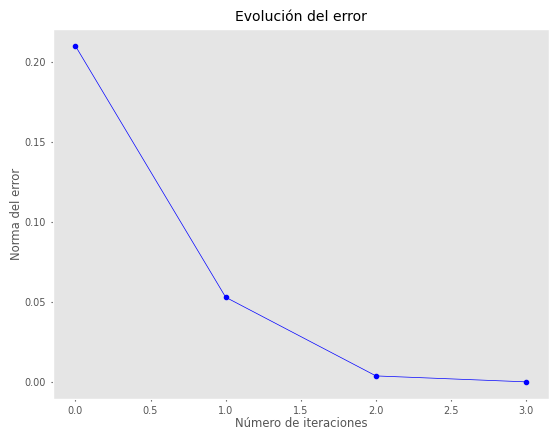

In [404]:
# Gráfico del error (debe ser decreciente)
plt.plot(e,'b')
plt.plot(e,'b.')
plt.title("Evolución del error"); plt.grid()
plt.xlabel("Número de iteraciones"); plt.ylabel("Norma del error");

## Cinematica inversa con robotic-toolbox

In [405]:
T = puma560.fkine([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
T

   0.1217   -0.6067   -0.7856    0.2478    
   0.8184    0.5092   -0.2665   -0.1259    
   0.5617   -0.6105    0.5584    1.146     
   0         0         0         1         


In [406]:
T = puma560.fkine( [0.1,    0.2,    0.3003, 0,     0,   0.6 ])
T

   0.6642   -0.5754   -0.4773    0.2477    
   0.6341    0.7718   -0.04789  -0.126     
   0.3959   -0.2709    0.8774    1.146     
   0         0         0         1         


In [407]:
T = puma560.fkine([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
sol = puma560.ikine_LM(T)                          
print(sol)

IKSolution: q=[2.101, 2.942, 2.936, -1.489, 0.953, 0.3326], success=True, iterations=8, searches=1, residual=4.87e-12


## Cargar el URDF

In [408]:
puma560_info = rtb.models.URDF.Puma560()
puma560_info

ERobot: Puma560 (by Unimation), 6 joints (RRRRRR), geometry, collision
┌─────┬────────┬───────┬────────┬───────────────────────────────────────────────────┐
│link │  link  │ joint │ parent │                ETS: parent to link                │
├─────┼────────┼───────┼────────┼───────────────────────────────────────────────────┤
│   0 │ link1  │       │ BASE   │ SE3()                                             │
│   1 │ link2  │     0 │ link1  │ SE3(0, 0, 0.5486; 90°, -0°, 0°) ⊕ Ry(q0)          │
│   2 │ link3  │     1 │ link2  │ SE3(0, 0.07493, 0.1422) ⊕ Rz(q1)                  │
│   3 │ link4  │     2 │ link3  │ SE3(0.4318, 0, 0.0254; 0°, -0°, 90°) ⊕ Rz(q2)     │
│   4 │ link5  │     3 │ link4  │ SE3(0.3518, 0, -0.0381; -90°, -0°, -90°) ⊕ Rz(q3) │
│   5 │ link6  │     4 │ link5  │ SE3(0, 0, 0.0803; 90°, -0°, 0°) ⊕ Rz(q4)          │
│   6 │ @link7 │     5 │ link6  │ SE3(0, 0.05334, 0; -90°, -0°, 0°) ⊕ Rz(q5)        │
└─────┴────────┴───────┴────────┴────────────────────────────────────

### posicion inicial

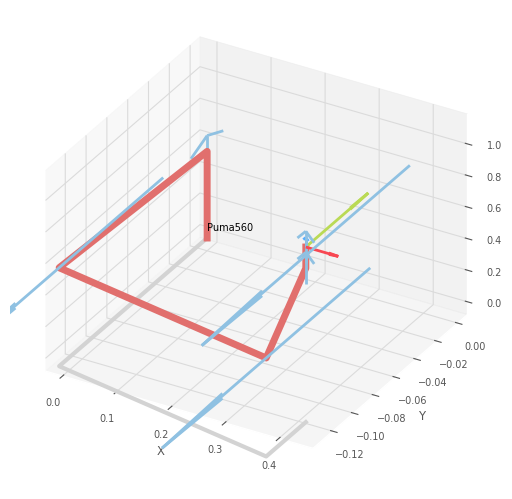

connection handler failed
Traceback (most recent call last):
  File "C:\Users\juano\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\websockets\legacy\protocol.py", line 959, in transfer_data
    message = await self.read_message()
              ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\juano\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\websockets\legacy\protocol.py", line 1029, in read_message
    frame = await self.read_data_frame(max_size=self.max_size)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\juano\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\websockets\legacy\protocol.py", line 1104, in read_data_frame
    frame = await self.read_frame(max_size)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\juano\A

In [447]:
puma560_info.plot(puma560_info.qz, backend="pyplot")
puma560_info.plot(puma560_info.qz, backend="swift")
print(puma560_info.qz)


### segunda posicion

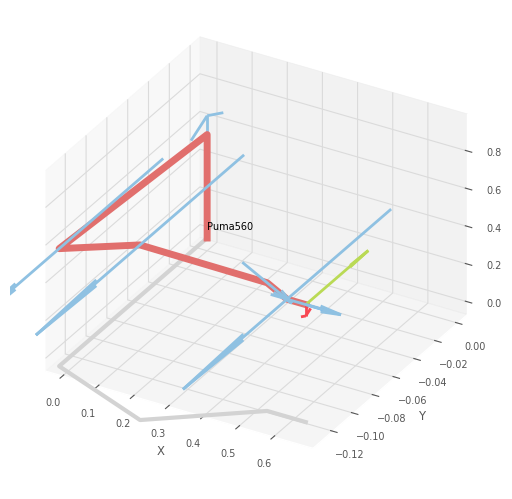

[0.         0.78539816 3.14159265 0.         0.78539816 0.        ]


<Figure size 640x480 with 0 Axes>

In [410]:
puma560_info.plot(puma560_info.qn, backend="pyplot")
puma560_info.plot(puma560_info.qn, backend="swift")
print(puma560_info.qn)

### tercera posicion


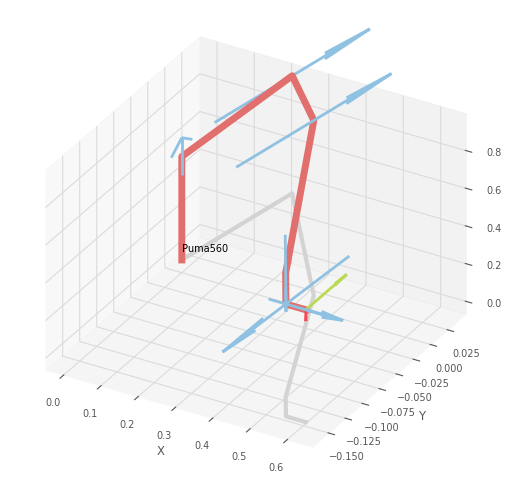

[ 2.6486 -3.927   0.094   2.5326  0.9743  0.3734]


<Figure size 640x480 with 0 Axes>

In [411]:
puma560_info.plot(puma560_info.lu, backend="pyplot")
puma560_info.plot(puma560_info.lu, backend="swift")
print(puma560_info.lu)

## Trayectoria de articulaciones

### trayectoria de articulaciones de posicion 1 a posicion 2

In [412]:
t = np.linspace(0, 1, 10)

In [413]:
traj = jtraj(puma560_info.qz, puma560_info.qn, t)
times = traj.t
configurations = traj.q

Tiempo: 0.0, Configuración: [-6.44900799e-14  9.93372051e-14 -2.24993635e-15 -5.73568970e-14
 -2.49522625e-14 -8.78463968e-15]


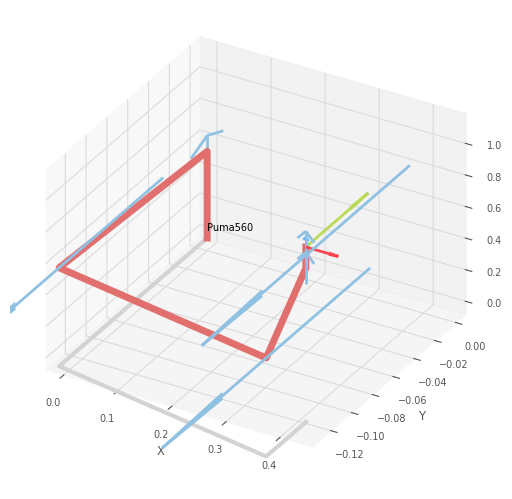

Tiempo: 0.1111111111111111, Configuración: [ 0.03054576 -0.04528929  0.00108408  0.02920796  0.0112364   0.00430635]


<Figure size 640x480 with 0 Axes>

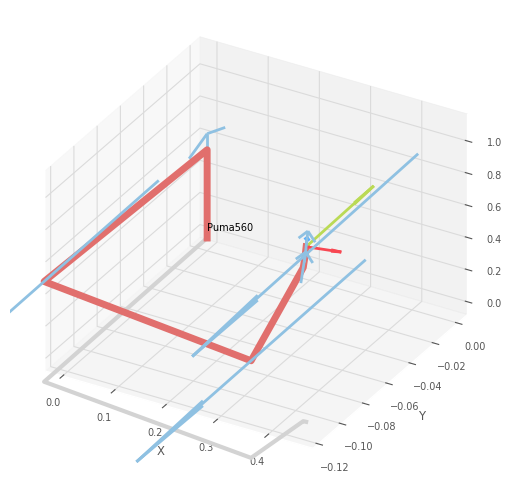

Tiempo: 0.2222222222222222, Configuración: [ 0.20238248 -0.30006645  0.00718264  0.19351879  0.07444735  0.02853191]


<Figure size 640x480 with 0 Axes>

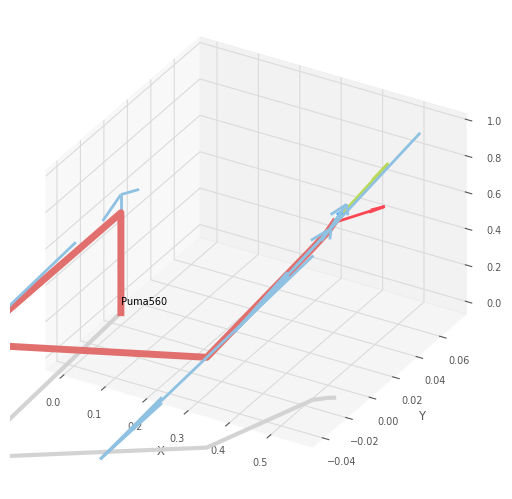

Tiempo: 0.3333333333333333, Configuración: [ 0.55587901 -0.82418519  0.0197284   0.53153333  0.20448272  0.0783679 ]


<Figure size 640x480 with 0 Axes>

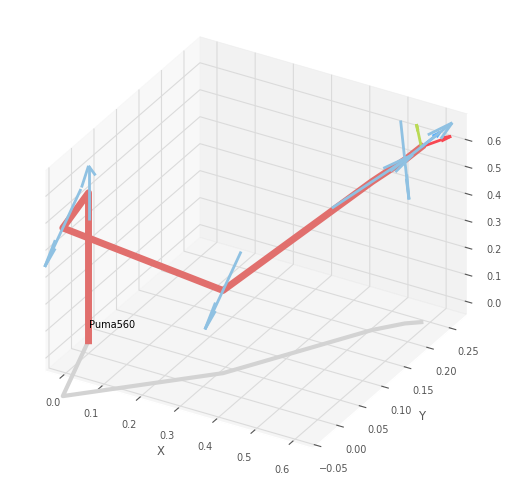

Tiempo: 0.4444444444444444, Configuración: [ 1.0506665  -1.5577918   0.03728862  1.00465075  0.38649263  0.14812311]


<Figure size 640x480 with 0 Axes>

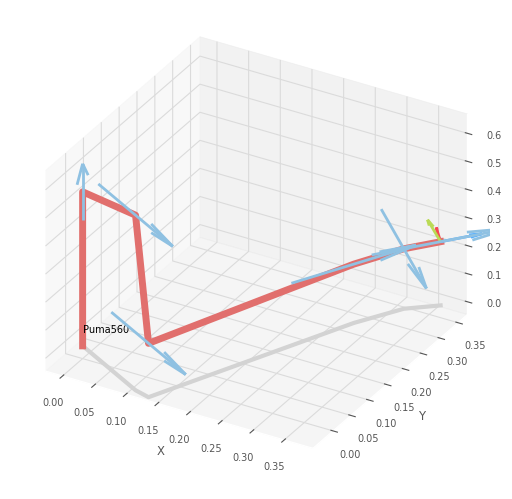

Tiempo: 0.5555555555555556, Configuración: [ 1.5979335  -2.3692082   0.05671138  1.52794925  0.58780737  0.22527689]


<Figure size 640x480 with 0 Axes>

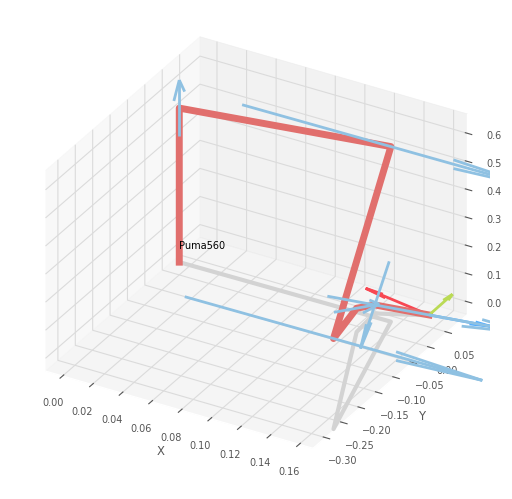

Tiempo: 0.6666666666666666, Configuración: [ 2.09272099 -3.10281481  0.0742716   2.00106667  0.76981728  0.2950321 ]


<Figure size 640x480 with 0 Axes>

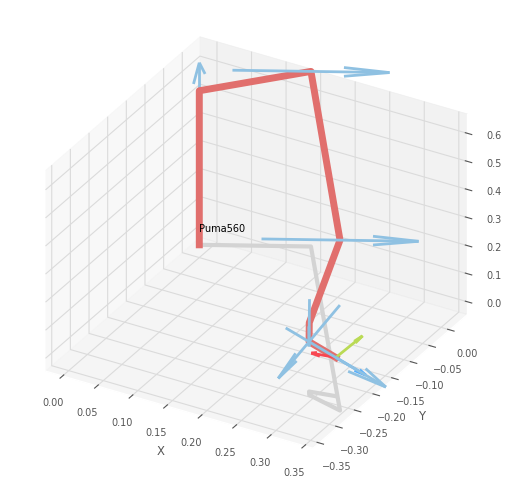

Tiempo: 0.7777777777777777, Configuración: [ 2.44621752 -3.62693355  0.08681736  2.33908121  0.89985265  0.34486809]


<Figure size 640x480 with 0 Axes>

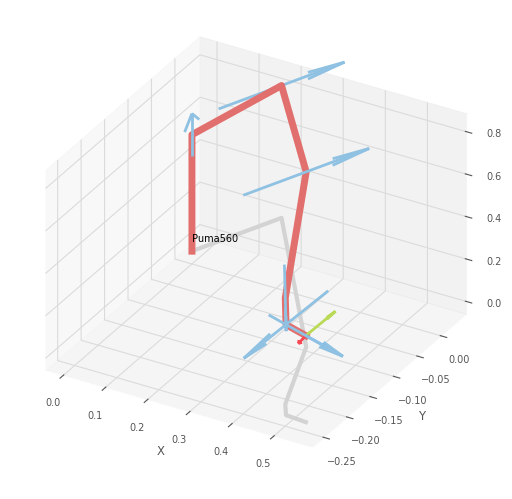

Tiempo: 0.8888888888888888, Configuración: [ 2.61805424 -3.88171071  0.09291592  2.50339204  0.9630636   0.36909365]


<Figure size 640x480 with 0 Axes>

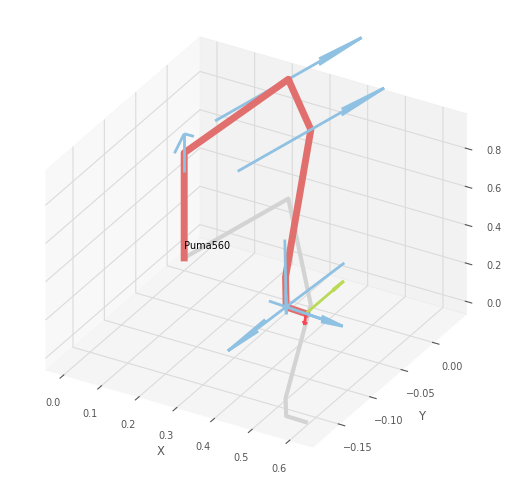

Tiempo: 1.0, Configuración: [ 2.6486 -3.927   0.094   2.5326  0.9743  0.3734]


<Figure size 640x480 with 0 Axes>

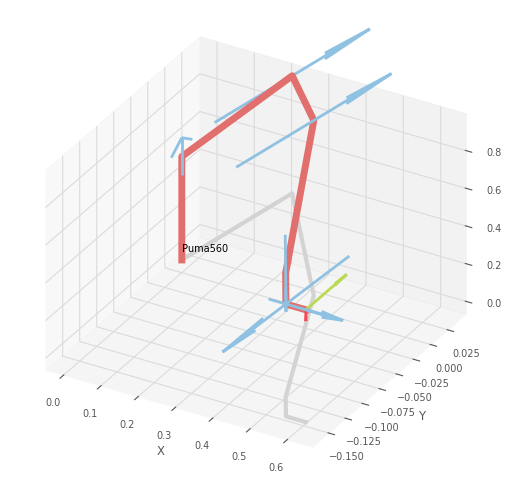

<Figure size 640x480 with 0 Axes>

In [442]:
for i in range(len(times)):
    print(f"Tiempo: {times[i]}, Configuración: {configurations[i]}")
    #puma560_info.plot(configurations[i], backend="pyplot")

### trayectoria de articulaciones de posicion 2 a posicion 3

In [415]:
t = np.linspace(0, 1, 10)

In [416]:
traj = jtraj(puma560_info.qn, puma560_info.lu, t)
times = traj.t
configurations = traj.q

In [417]:
for i in range(len(times)):
    print(f"Tiempo: {times[i]}, Configuración: {configurations[i]}")
    #puma560_info.plot(configurations[i], backend="pyplot")

Tiempo: 0.0, Configuración: [0.         0.78539816 3.14159265 0.         0.78539816 0.        ]
Tiempo: 0.1111111111111111, Configuración: [0.03054576 0.73105104 3.10644539 0.02920796 0.78757673 0.00430635]
Tiempo: 0.2222222222222222, Configuración: [0.20238248 0.42531856 2.9087227  0.19351879 0.79983236 0.02853191]
Tiempo: 0.3333333333333333, Configuración: [ 0.55587901 -0.20362367  2.50197444  0.53153333  0.82504423  0.0783679 ]
Tiempo: 0.4444444444444444, Configuración: [ 1.0506665  -1.08395127  1.93265075  1.00465075  0.86033316  0.14812311]
Tiempo: 0.5555555555555556, Configuración: [ 1.5979335  -2.05765057  1.3029419   1.52794925  0.899365    0.22527689]
Tiempo: 0.6666666666666666, Configuración: [ 2.09272099 -2.93797816  0.73361821  2.00106667  0.93465394  0.2950321 ]
Tiempo: 0.7777777777777777, Configuración: [ 2.44621752 -3.5669204   0.32686996  2.33908121  0.9598658   0.34486809]
Tiempo: 0.8888888888888888, Configuración: [ 2.61805424 -3.87265288  0.12914726  2.50339204  0.97

### trayectoria de articulaciones de posicion 1 a posicion 3

In [418]:
t = np.linspace(0, 1, 10)

In [419]:
traj = jtraj(puma560_info.qz, puma560_info.lu, t)
times = traj.t
configurations = traj.q

In [420]:
for i in range(len(times)):
    print(f"Tiempo: {times[i]}, Configuración: {configurations[i]}")
    #puma560_info.plot(configurations[i], backend="pyplot")

Tiempo: 0.0, Configuración: [0. 0. 0. 0. 0. 0.]
Tiempo: 0.1111111111111111, Configuración: [ 0.03054576 -0.04528929  0.00108408  0.02920796  0.0112364   0.00430635]
Tiempo: 0.2222222222222222, Configuración: [ 0.20238248 -0.30006645  0.00718264  0.19351879  0.07444735  0.02853191]
Tiempo: 0.3333333333333333, Configuración: [ 0.55587901 -0.82418519  0.0197284   0.53153333  0.20448272  0.0783679 ]
Tiempo: 0.4444444444444444, Configuración: [ 1.0506665  -1.5577918   0.03728862  1.00465075  0.38649263  0.14812311]
Tiempo: 0.5555555555555556, Configuración: [ 1.5979335  -2.3692082   0.05671138  1.52794925  0.58780737  0.22527689]
Tiempo: 0.6666666666666666, Configuración: [ 2.09272099 -3.10281481  0.0742716   2.00106667  0.76981728  0.2950321 ]
Tiempo: 0.7777777777777777, Configuración: [ 2.44621752 -3.62693355  0.08681736  2.33908121  0.89985265  0.34486809]
Tiempo: 0.8888888888888888, Configuración: [ 2.61805424 -3.88171071  0.09291592  2.50339204  0.9630636   0.36909365]
Tiempo: 1.0, Con

## Trayectoria carteciana

### trayectoria carteciana de la posicion 1 a la posicion 2

In [421]:
t = np.linspace(0, 1, 10)
tacc = 0.1

In [422]:
qz = puma560_info.fkine(puma560_info.qz)
qn = puma560_info.fkine(puma560_info.qn)

In [423]:
cetraj = ctraj(qz, qn, t)
times = t
poses = cetraj
configurations = cetraj.t    

Tiempo: 0.0
Pose: 
   1         0         0         0.4318    
   0         1         0        -0.1295    
   0         0         1         1.109     
   0         0         0         1         

configurations: [-6.44900799e-14  9.93372051e-14 -2.24993635e-15 -5.73568970e-14
 -2.49522625e-14 -8.78463968e-15]


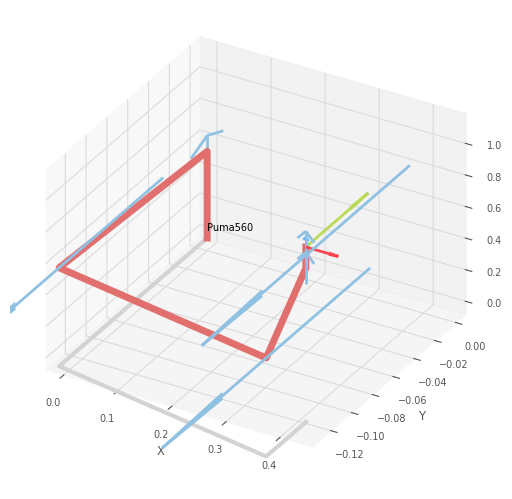

Tiempo: 0.1111111111111111
Pose: 
   0.999    -6.134e-07  0.04362   0.4372    
   6.613e-07  1        -1.083e-06 -0.1304    
  -0.04362   1.111e-06  0.999     1.095     
   0         0         0         1         

configurations: [ 0.03054576 -0.04528929  0.00108408  0.02920796  0.0112364   0.00430635]


<Figure size 640x480 with 0 Axes>

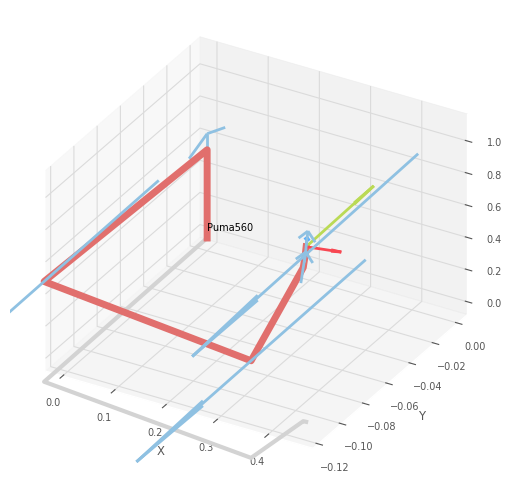

Tiempo: 0.2222222222222222
Pose: 
   0.9848   -2.155e-06  0.1737    0.4534    
   2.919e-06  1        -4.146e-06 -0.133     
  -0.1737    4.59e-06  0.9848    1.052     
   0         0         0         1         

configurations: [ 0.20238248 -0.30006645  0.00718264  0.19351879  0.07444735  0.02853191]


<Figure size 640x480 with 0 Axes>

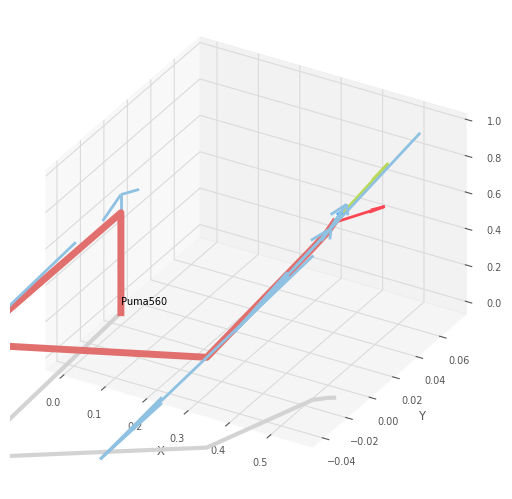

Tiempo: 0.3333333333333333
Pose: 
   0.9239   -3.677e-06  0.3827    0.4804    
   7.506e-06  1        -8.514e-06 -0.1373    
  -0.3827    1.074e-05  0.9239    0.9808    
   0         0         0         1         

configurations: [ 0.55587901 -0.82418519  0.0197284   0.53153333  0.20448272  0.0783679 ]


<Figure size 640x480 with 0 Axes>

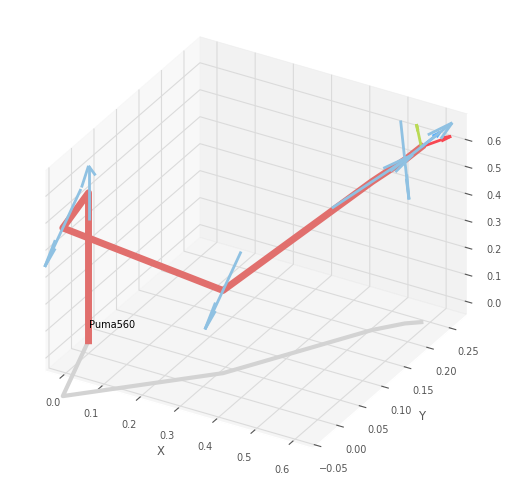

Tiempo: 0.4444444444444444
Pose: 
   0.7933   -3.697e-06  0.6088    0.5128    
   1.409e-05  1        -1.229e-05 -0.1426    
  -0.6088    1.833e-05  0.7933    0.8953    
   0         0         0         1         

configurations: [ 1.0506665  -1.5577918   0.03728862  1.00465075  0.38649263  0.14812311]


<Figure size 640x480 with 0 Axes>

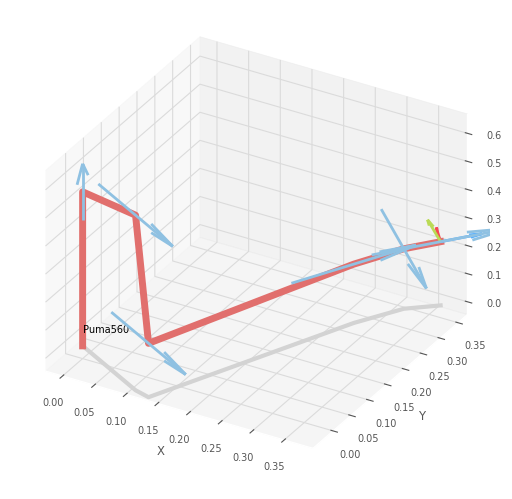

Tiempo: 0.5555555555555556
Pose: 
   0.6087   -1.75e-06  0.7934    0.5453    
   2.143e-05  1        -1.424e-05 -0.1478    
  -0.7934    2.567e-05  0.6087    0.8098    
   0         0         0         1         

configurations: [ 1.5979335  -2.3692082   0.05671138  1.52794925  0.58780737  0.22527689]


<Figure size 640x480 with 0 Axes>

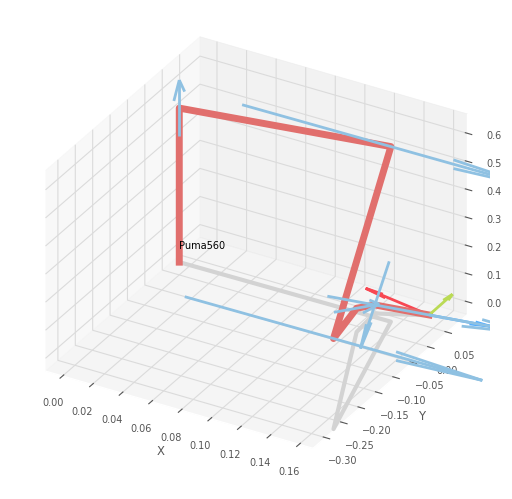

Tiempo: 0.6666666666666666
Pose: 
   0.3826    2.03e-06  0.9239    0.5777    
   2.903e-05  1        -1.422e-05 -0.153     
  -0.9239    3.226e-05  0.3826    0.7243    
   0         0         0         1         

configurations: [ 2.09272099 -3.10281481  0.0742716   2.00106667  0.76981728  0.2950321 ]


<Figure size 640x480 with 0 Axes>

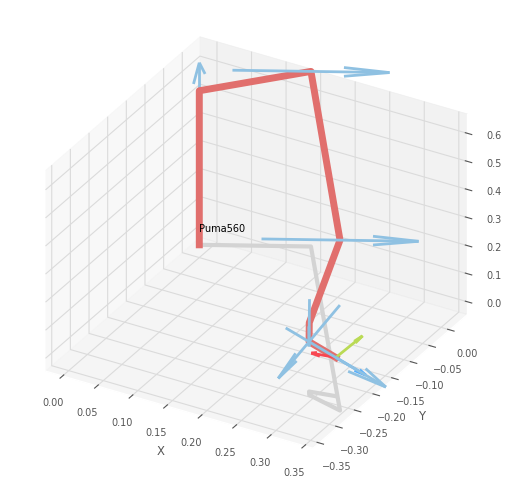

Tiempo: 0.7777777777777777
Pose: 
   0.1736    6.398e-06  0.9848    0.6047    
   3.518e-05  1        -1.27e-05 -0.1573    
  -0.9848    3.685e-05  0.1736    0.653     
   0         0         0         1         

configurations: [ 2.44621752 -3.62693355  0.08681736  2.33908121  0.89985265  0.34486809]


<Figure size 640x480 with 0 Axes>

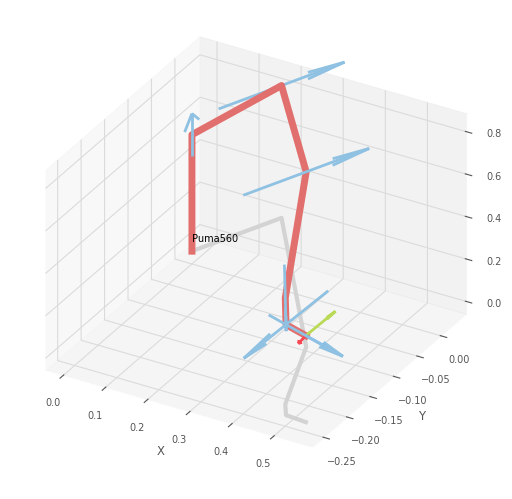

Tiempo: 0.8888888888888888
Pose: 
   0.04356   9.461e-06  0.9991    0.6209    
   3.865e-05  1        -1.115e-05 -0.1599    
  -0.9991    3.91e-05  0.04356   0.6103    
   0         0         0         1         

configurations: [ 2.61805424 -3.88171071  0.09291592  2.50339204  0.9630636   0.36909365]


<Figure size 640x480 with 0 Axes>

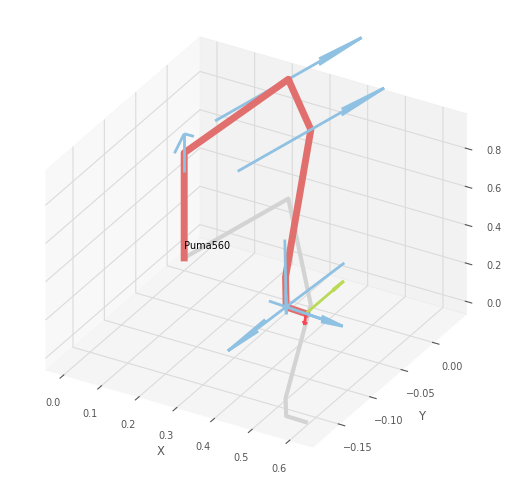

Tiempo: 1.0
Pose: 
  -6.474e-05  1.054e-05  1         0.6263    
   3.977e-05  1        -1.054e-05 -0.1608    
  -1         3.977e-05 -6.474e-05  0.596     
   0         0         0         1         

configurations: [ 2.6486 -3.927   0.094   2.5326  0.9743  0.3734]


<Figure size 640x480 with 0 Axes>

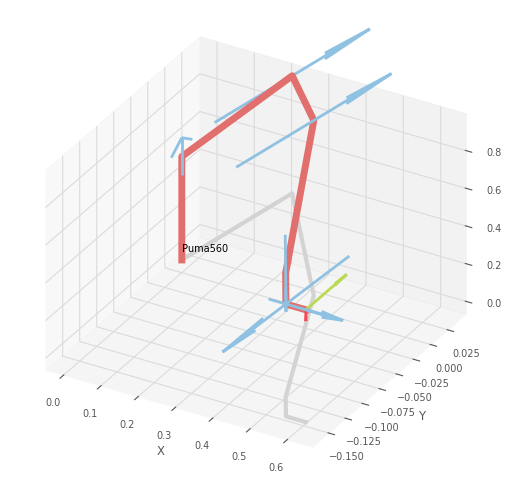

<Figure size 640x480 with 0 Axes>

In [443]:
for i in range(len(times)):
    print(f"Tiempo: {times[i]}")
    print("Pose: ")
    print(poses[i])
    print(f"configurations: {configurations[i]}")
    #puma560_info.plot(configurations[i], backend="pyplot")

### trayectoria carteciana de la posicion 2 a la posicion 3

In [425]:
qn = puma560_info.fkine(puma560_info.qn)
lu = puma560_info.fkine(puma560_info.lu)

In [426]:
cetraj = ctraj(qn, lu, t)
times = t
poses = cetraj
configurations = cetraj.t    

In [427]:
for i in range(len(times)):
    print(f"Tiempo: {times[i]}")
    print("Pose: ")
    print(poses[i])
    print(f"configurations: {configurations[i]}")
    #puma560_info.plot(configurations[i], backend="pyplot")

Tiempo: 0.0
Pose: 
   0         1.795e-09  1         0.6642    
  -1.795e-09  1        -1.795e-09 -0.1295    
  -1        -1.795e-09  0         0.6234    
   0         0         0         1         

configurations: [ 0.66420177 -0.12954     0.62336565]
Tiempo: 0.1111111111111111
Pose: 
  -1.798e-06  2.946e-07  1         0.6631    
   1.103e-06  1        -2.946e-07 -0.1304    
  -1         1.103e-06 -1.798e-06  0.6226    
   0         0         0         1         

configurations: [ 0.6631494  -0.13040763  0.62260656]
Tiempo: 0.2222222222222222
Pose: 
  -7.194e-06  1.173e-06  1         0.66      
   4.417e-06  1        -1.173e-06 -0.133     
  -1         4.417e-06 -7.194e-06  0.6203    
   0         0         0         1         

configurations: [ 0.65999229 -0.13301053  0.6203293 ]
Tiempo: 0.3333333333333333
Pose: 
  -1.619e-05  2.637e-06  1         0.6547    
   9.94e-06  1        -2.637e-06 -0.1373    
  -1         9.94e-06 -1.619e-05  0.6165    
   0         0         0         1

### trayectoria carteciana de la posicion 1 a la posicion 3

In [428]:
qz = puma560_info.fkine(puma560_info.qz)
lu = puma560_info.fkine(puma560_info.lu)

In [429]:
cetraj = ctraj(qz, lu, t)
times = t
poses = cetraj
configurations = cetraj.t    

In [430]:
for i in range(len(times)):
    print(f"Tiempo: {times[i]}")
    print("Pose: ")
    print(poses[i])
    print(f"configurations: {configurations[i]}")
    #puma560_info.plot(configurations[i], backend="pyplot")

Tiempo: 0.0
Pose: 
   1         0         0         0.4318    
   0         1         0        -0.1295    
   0         0         1         1.109     
   0         0         0         1         

configurations: [ 0.4318   -0.12954   1.108999]
Tiempo: 0.1111111111111111
Pose: 
   0.999    -6.134e-07  0.04362   0.4372    
   6.613e-07  1        -1.083e-06 -0.1304    
  -0.04362   1.111e-06  0.999     1.095     
   0         0         0         1         

configurations: [ 0.43720323 -0.13040763  1.0947501 ]
Tiempo: 0.2222222222222222
Pose: 
   0.9848   -2.155e-06  0.1737    0.4534    
   2.919e-06  1        -4.146e-06 -0.133     
  -0.1737    4.59e-06  0.9848    1.052     
   0         0         0         1         

configurations: [ 0.45341293 -0.13301053  1.05200339]
Tiempo: 0.3333333333333333
Pose: 
   0.9239   -3.677e-06  0.3827    0.4804    
   7.506e-06  1        -8.514e-06 -0.1373    
  -0.3827    1.074e-05  0.9239    0.9808    
   0         0         0         1         

conf

## Trayectoria de movimiento

### trayectoria de movimiento de la posicion 1 a la posicion 2

In [431]:
metraj = mtraj(quintic, puma560_info.qz, puma560_info.qn, t)

In [432]:
times = metraj.t
configurations = metraj.q

for i in range(len(times)):
    print(f"Tiempo: {times[i]}, Configuración: {configurations[i]}")
    #puma560_info.plot(configurations[i], backend="pyplot")

Tiempo: 0.0, Configuración: [ 0.00000000e+00 -1.81174520e-14 -7.24698079e-14  0.00000000e+00
 -1.81174520e-14  0.00000000e+00]
Tiempo: 0.1111111111111111, Configuración: [0.         0.00905784 0.03623134 0.         0.00905784 0.        ]
Tiempo: 0.2222222222222222, Configuración: [0.         0.06001315 0.2400526  0.         0.06001315 0.        ]
Tiempo: 0.3333333333333333, Configuración: [0.         0.16483665 0.65934661 0.         0.16483665 0.        ]
Tiempo: 0.4444444444444444, Configuración: [0.         0.31155763 1.24623053 0.         0.31155763 0.        ]
Tiempo: 0.5555555555555556, Configuración: [0.         0.47384053 1.89536213 0.         0.47384053 0.        ]
Tiempo: 0.6666666666666666, Configuración: [0.         0.62056151 2.48224605 0.         0.62056151 0.        ]
Tiempo: 0.7777777777777777, Configuración: [0.         0.72538501 2.90154005 0.         0.72538501 0.        ]
Tiempo: 0.8888888888888888, Configuración: [0.         0.77634033 3.10536131 0.         0.776340

### trayectoria de movimiento de la posicion 2 a la posicion 3

In [433]:
metraj = mtraj(quintic, puma560_info.qn, puma560_info.lu, t)

Tiempo: 0.0, Configuración: [-6.44900799e-14  9.93372051e-14 -2.24993635e-15 -5.73568970e-14
 -2.49522625e-14 -8.78463968e-15]


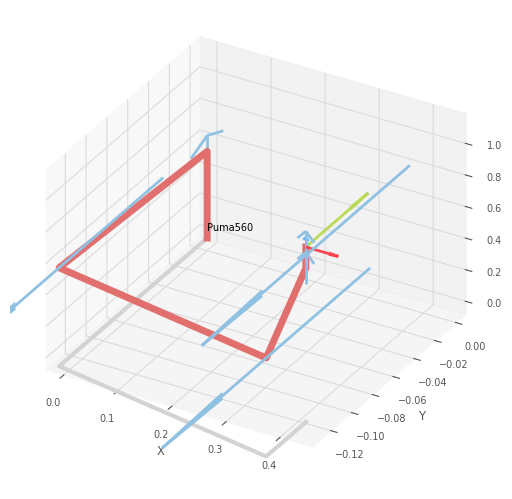

Tiempo: 0.1111111111111111, Configuración: [ 0.03054576 -0.04528929  0.00108408  0.02920796  0.0112364   0.00430635]


<Figure size 640x480 with 0 Axes>

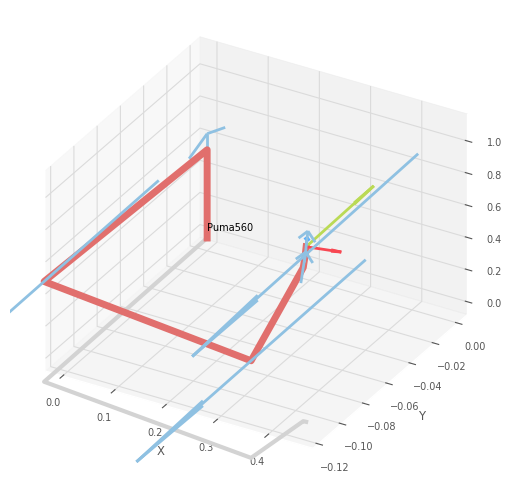

Tiempo: 0.2222222222222222, Configuración: [ 0.20238248 -0.30006645  0.00718264  0.19351879  0.07444735  0.02853191]


<Figure size 640x480 with 0 Axes>

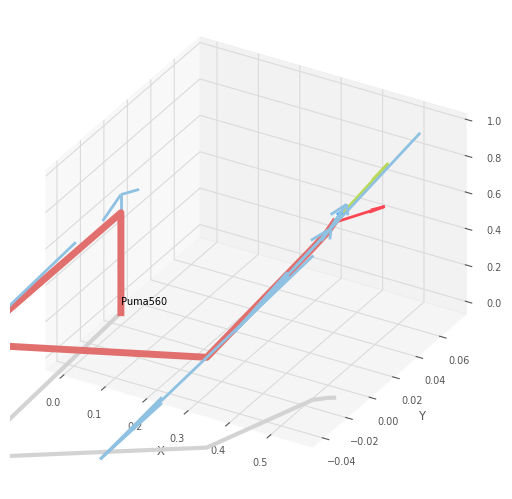

Tiempo: 0.3333333333333333, Configuración: [ 0.55587901 -0.82418519  0.0197284   0.53153333  0.20448272  0.0783679 ]


<Figure size 640x480 with 0 Axes>

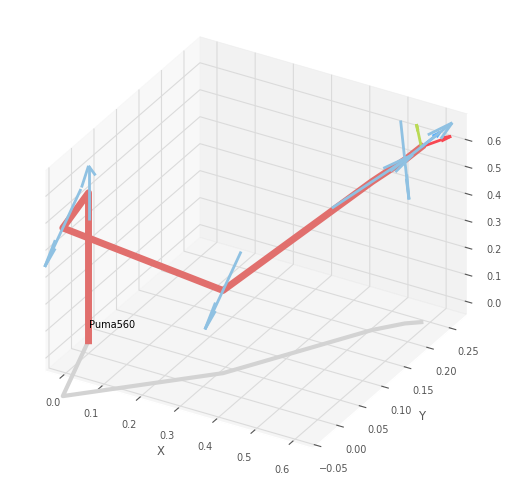

Tiempo: 0.4444444444444444, Configuración: [ 1.0506665  -1.5577918   0.03728862  1.00465075  0.38649263  0.14812311]


<Figure size 640x480 with 0 Axes>

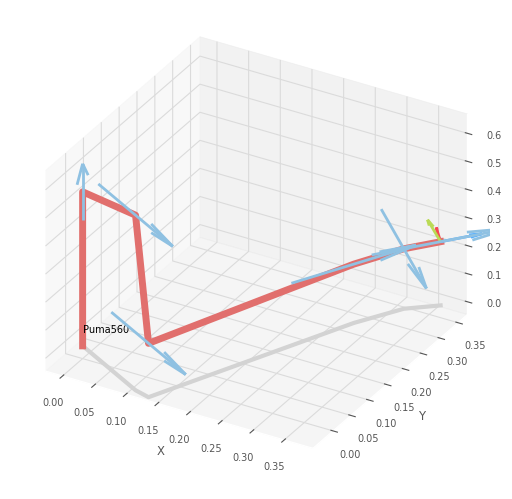

Tiempo: 0.5555555555555556, Configuración: [ 1.5979335  -2.3692082   0.05671138  1.52794925  0.58780737  0.22527689]


<Figure size 640x480 with 0 Axes>

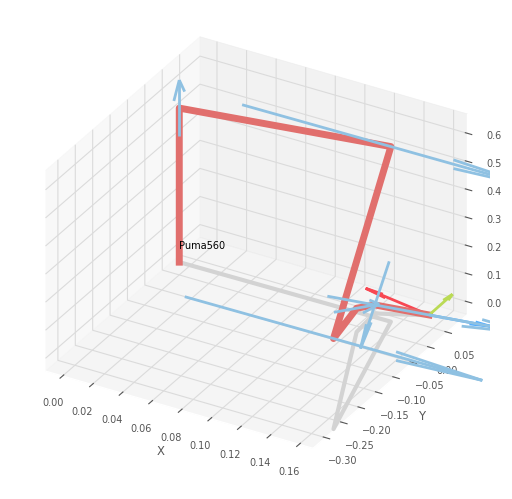

Tiempo: 0.6666666666666666, Configuración: [ 2.09272099 -3.10281481  0.0742716   2.00106667  0.76981728  0.2950321 ]


<Figure size 640x480 with 0 Axes>

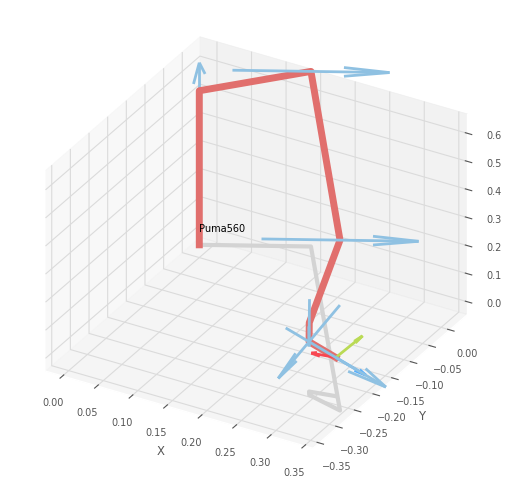

Tiempo: 0.7777777777777777, Configuración: [ 2.44621752 -3.62693355  0.08681736  2.33908121  0.89985265  0.34486809]


<Figure size 640x480 with 0 Axes>

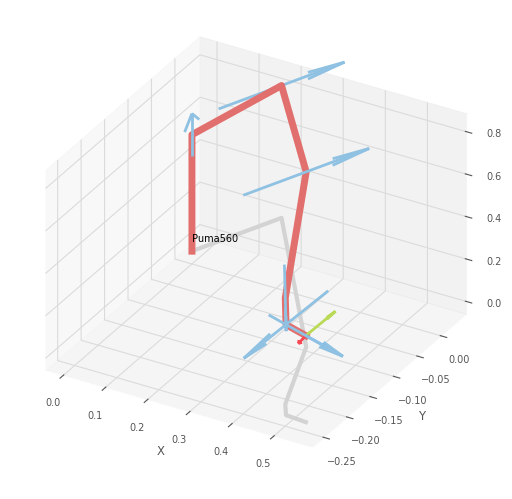

Tiempo: 0.8888888888888888, Configuración: [ 2.61805424 -3.88171071  0.09291592  2.50339204  0.9630636   0.36909365]


<Figure size 640x480 with 0 Axes>

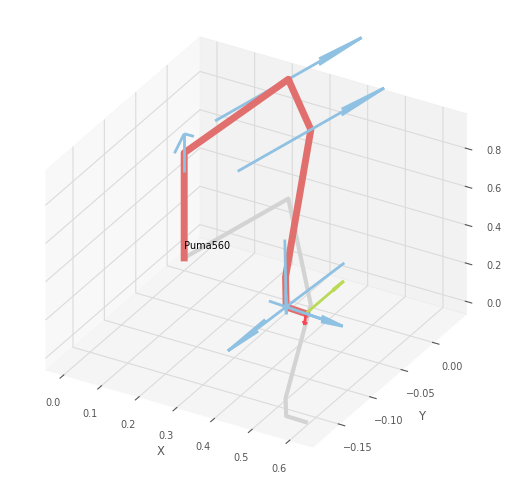

Tiempo: 1.0, Configuración: [ 2.6486 -3.927   0.094   2.5326  0.9743  0.3734]


<Figure size 640x480 with 0 Axes>

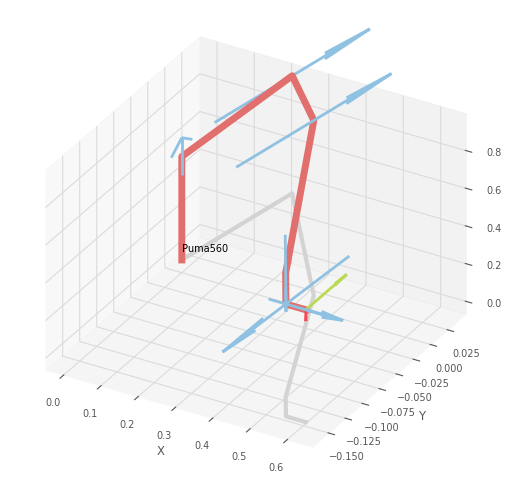

<Figure size 640x480 with 0 Axes>

In [441]:
times = metraj.t
configurations = metraj.q

for i in range(len(times)):
    print(f"Tiempo: {times[i]}, Configuración: {configurations[i]}")
    #puma560_info.plot(configurations[i], backend="pyplot")

### trayectoria de movimiento de la posicion 1 a la posicion 3

In [436]:
metraj = mtraj(quintic, puma560_info.qz, puma560_info.lu, t)

In [439]:
times = metraj.t
configurations = metraj.q

for i in range(len(times)):
    print(f"Tiempo: {times[i]}, Configuración: {configurations[i]}")
    #puma560_info.plot(configurations[i], backend="pyplot")

Tiempo: 0.0, Configuración: [-6.44900799e-14  9.93372051e-14 -2.24993635e-15 -5.73568970e-14
 -2.49522625e-14 -8.78463968e-15]
Tiempo: 0.1111111111111111, Configuración: [ 0.03054576 -0.04528929  0.00108408  0.02920796  0.0112364   0.00430635]
Tiempo: 0.2222222222222222, Configuración: [ 0.20238248 -0.30006645  0.00718264  0.19351879  0.07444735  0.02853191]
Tiempo: 0.3333333333333333, Configuración: [ 0.55587901 -0.82418519  0.0197284   0.53153333  0.20448272  0.0783679 ]
Tiempo: 0.4444444444444444, Configuración: [ 1.0506665  -1.5577918   0.03728862  1.00465075  0.38649263  0.14812311]
Tiempo: 0.5555555555555556, Configuración: [ 1.5979335  -2.3692082   0.05671138  1.52794925  0.58780737  0.22527689]
Tiempo: 0.6666666666666666, Configuración: [ 2.09272099 -3.10281481  0.0742716   2.00106667  0.76981728  0.2950321 ]
Tiempo: 0.7777777777777777, Configuración: [ 2.44621752 -3.62693355  0.08681736  2.33908121  0.89985265  0.34486809]
Tiempo: 0.8888888888888888, Configuración: [ 2.6180542

In [ ]:
puma560_info.plot(configurations[1], backend="pyplot")
print(puma560_info.qz)